In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
import pandas as pd

In [6]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError, msg:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [10]:
import json

data = []

file_names = ['readings_15.txt','readings_20.txt','readings_48.txt','readings_59_5.txt']
laser_distance = [15,20,48,59.5]
for i in xrange(len(file_names)):
    with open(file_names[i]) as f:
        for line in f:
            dict_obj = json.loads(line)
            dict_obj['camera_distance'] = laser_distance[i] 
            data.append(dict_obj)            
print("Length of data",len(data))

('Length of data', 4460)


In [11]:
np_data = []
predictions = []
for obj in data:
    data_point1 = []
    data_point1.append(obj['camera1'][0])
    data_point1.append(obj['camera1'][1])
    
    data_point1.append(obj['camera2'][0])
    data_point1.append(obj['camera2'][1])
    
    data_point1.append(obj['camera_distance'])
    yhat = savitzky_golay(np.array(obj['laser'])[:,0], 11, 1)
    np_data.append(data_point1)
    predictions.append(np.min(yhat))

In [12]:
mlpR = MLPRegressor(hidden_layer_sizes=(200),activation='logistic',)
a_train, a_test, b_train, b_test  = train_test_split(np_data, predictions, test_size=0.33, random_state=42)
mlpR.fit(a_train,b_train,)
pred = mlpR.predict(a_test)

In [13]:
mean_absolute_error(pred,b_test)

0.029166961588467516

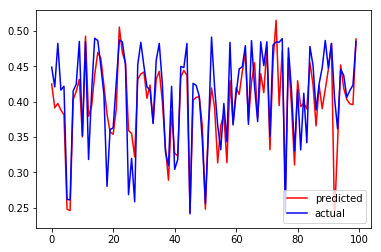

In [19]:
plt.plot(pred[0:100],color='r',label='predicted')
plt.plot(b_test[0:100],color='b',label='actual')
plt.legend()
plt.savefig("/home/dell/datascience/farm_project/plot.png")

In [20]:
from sklearn.model_selection import cross_val_score
mlpR = MLPRegressor(hidden_layer_sizes=(200),activation='logistic')
mse_values = cross_val_score(mlpR, np_data, predictions, cv=10,scoring='mean_absolute_error')
print "Mean is",np.mean(mse_values)
print(mse_values)

/home/dell/.local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/dell/.local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/dell/.local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/dell/.local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/home/dell/.

Mean is -0.03222299378707094
[-0.03792487 -0.03938593 -0.07809354 -0.01922443 -0.0458622  -0.02429879
 -0.02325187 -0.01680535 -0.01768041 -0.01970255]


/home/dell/.local/lib/python2.7/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_absolute_error was renamed to neg_mean_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


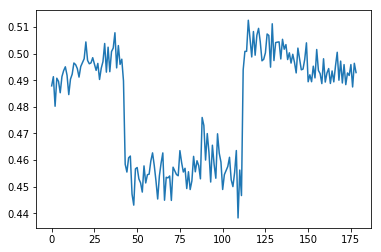

In [21]:
plt.plot(np.array(data[3500]['laser'])[:,0])
plt.savefig("/home/dell/datascience/farm_project/laser_profile.png")

In [ ]:
plt.plot(np.array(data[3500]['laser'])[:,0])

In [97]:
yhat = savitzky_golay(np.array(data[3500]['laser'])[:,0], , 1)

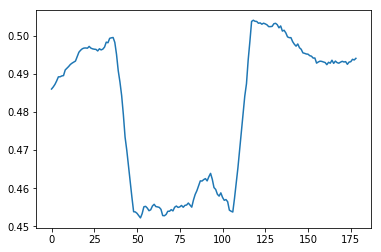

In [98]:
plt.plot(yhat)

In [16]:
df = pd.DataFrame(np_data)

In [17]:
df.columns = ['Camera1_u','Camera1_v','Camera2_u','Camera2_v','Camera Distance']

In [18]:
df.head()

Camera1_u  Camera1_v  Camera2_u  Camera2_v  Camera Distance
0      234.0       29.0      306.0       10.0             15.0
1      234.0       29.0      306.0        9.0             15.0
2      234.0       30.0      306.0        9.0             15.0
3      216.0       35.0      286.0       16.0             15.0
4      216.0       35.0      286.0       16.0             15.0